In [8]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import Session, QiskitRuntimeService, SamplerV2 as Sampler
#from qiskit.transpiler import preset_passmanagers, PassManagerConfig
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager#, level_0_pass_manager

#from qiskit_aer import AerSimulator
#from qiskit_ibm_runtime.fake_provider import FakeCusco
#from qiskit import transpile

from datetime import datetime
import numpy as np
import csv

# API tokens for IBM Quantum Platform. Updated on 04-Dec-2024.

## Account Information

### KQC_Pharmcadd
### ibm-q-kqc / pharcadd / research OR ibm-q / open / main
token = 'e2b36571a4a8ed3720a30c8d7b2d59b55347beebe48614832e74a156a3669e6179d306b2ff3727f08ef95b99c1166add2a774e80fff85405abe38a0da1eb1c8c'

instances = [marrakesh, fez (156), torino (133), brussels, nazca, strasbourg, {kyiv, brisbane, sherbrooke} (127)]

### my account: ichi@kaist
### ibm-q-skku / kaist / kaist-graduate OR ibm-q / open / main
token = '23b4b9e4f3507d73dd25691b5b96bc6a70ab7798ea6821b91db525151323338264a62e5adfff61edb604f62fcaa51a4484a54450bb239b8c52e8d1ccd76344c2'

instances = [marrakesh, fez (156), torino (133), brussels, nazca, strasbourg, {kyiv, brisbane, sherbrooke} (127)]

Usage limits (open): Monthly usage is limited up to 10 minutes, refreshes on the first of each month. At most 3 pending workloads at a time.

## Load QiskitRuntimeService

In [9]:
# Show the list of the saved accounts
saved_accounts = QiskitRuntimeService.saved_accounts()

#for key, value in saved_accounts.items():
#    print(key, value)

In [10]:
# Load account and generate QiskitRuntimeService
default_account = saved_accounts['kaist_ichi9505']
service = QiskitRuntimeService(channel=default_account['channel'],token=default_account['token'])

# Error verification

## conduct quantum experiments on ibm backend : error verification

In [11]:
### set instructions for experiments
backend = service.least_busy()
print(backend.name)

ibm_kyiv


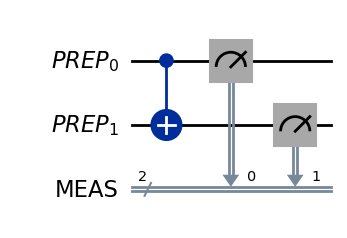

In [12]:
initial_layout = [62,61,72,63,60,81,64]
shots_per_experiment = 8000
repetitions_to_get_stats = 30
num_targets = 1

### construct the quantum circuit for verifying error rates of SPAM and CNOT gate.
qr_sa = QuantumRegister(2, name='PREP')
cr_meas = ClassicalRegister(2, name='MEAS')
qc_veri = QuantumCircuit(qr_sa,cr_meas, name="VERIFIER")
qc_veri.cx(qr_sa[0],qr_sa[1])
qc_veri.measure(qr_sa,cr_meas)

qc_veri.draw('mpl')

In [13]:
### do experiments
backend_properties = backend.properties().to_dict()
datetime_experiment_veri = datetime.utcnow()

qubit_ctrl = initial_layout[0]
qubits_target = initial_layout[1:num_targets+1]

counts_all_experiments = []
for target in qubits_target:
    # DISPLAY INFORMATION : backend_name, system_qubit, anc_qubit, shots, reps #
    print('==============================')
    print("|     Experiment details     |")
    print('------------------------------')
    print('- date: {} (UTC+00)'.format(datetime_experiment_veri))
    print('- backend: {}'.format(backend.name))
    print('- system_ancilla: {0}->{1}'.format(qubit_ctrl,target))
    print('- # shots: {}'.format(shots_per_experiment))
    print('- # repetitions: {}'.format(repetitions_to_get_stats))
    print("-+ 'little-endian': qn ... q1 q0")
    
    # SET PASSMANAGER #
    pm = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=[qubit_ctrl,target])
    isa_circuit = pm.run(qc_veri)
    with Session(backend=backend) as session:
        for rep in range(repetitions_to_get_stats):
            # RUN EXPERIMENT #
            sampler = Sampler(session=session)
            job = sampler.run([isa_circuit], shots=shots_per_experiment)
            
            # SAVE COUNTS #
            pub_results = job.result()[0]['__value__']['data']
            pub_counts = pub_results.MEAS.get_counts()
            if '00' not in pub_counts.keys():
                pub_counts['00'] = 0
            if '01' not in pub_counts.keys():
                pub_counts['01'] = 0
            if '10' not in pub_counts.keys():
                pub_counts['10'] = 0
            if '11' not in pub_counts.keys():
                pub_counts['11'] = 0
            counts_all_experiments.append(pub_counts)
            
            # DISPLAY RESULT : rep, counts(little-endian: qr[0] most right) #
            print("-+ ({2}-th) {3}".format(qubit_ctrl, target, rep, pub_counts))

print('------------------------------')
print("|            Done            |")
print('==============================')

|     Experiment details     |
------------------------------
- date: 2024-12-11 00:33:12.632208 (UTC+00)
- backend: ibm_kyiv
- system_ancilla: 62->61
- # shots: 8000
- # repetitions: 30
-+ 'little-endian': qn ... q1 q0
-+ (0-th) {'00': 7674, '01': 115, '11': 132, '10': 79}
-+ (1-th) {'00': 7707, '01': 128, '10': 63, '11': 102}
-+ (2-th) {'00': 7579, '01': 184, '11': 173, '10': 64}
-+ (3-th) {'00': 7635, '01': 135, '11': 157, '10': 73}
-+ (4-th) {'00': 7737, '01': 113, '11': 108, '10': 42}
-+ (5-th) {'00': 7682, '11': 130, '01': 124, '10': 64}
-+ (6-th) {'00': 7695, '10': 65, '01': 117, '11': 123}
-+ (7-th) {'00': 7668, '01': 133, '11': 125, '10': 74}
-+ (8-th) {'00': 7702, '11': 108, '01': 120, '10': 70}
-+ (9-th) {'00': 7678, '01': 130, '11': 128, '10': 64}
-+ (10-th) {'00': 7659, '01': 125, '11': 153, '10': 63}
-+ (11-th) {'00': 7653, '11': 129, '01': 138, '10': 80}
-+ (12-th) {'00': 7681, '11': 123, '10': 75, '01': 121}
-+ (13-th) {'00': 7655, '11': 153, '01': 117, '10': 75}
-+ (14

### statistical analysis

In [14]:
avg_freqs_all_experiments = {} # averaged
stddevs_all_experiments = {}
# median_all_experiments = {}

for target in range(num_targets):
    avg_freqs_experiment = {'00':0,'01':0,'10':0,'11':0} # big-endian dictionary
    stddevs_experiment = {'00':0,'01':0,'10':0,'11':0} # big-endian dictionary
    for rep in range(repetitions_to_get_stats):
        for outcome in avg_freqs_experiment.keys():
                                                                    #┌> index_data                        #┌> little to big-endian
            avg_freqs_experiment[outcome] += counts_all_experiments[target*repetitions_to_get_stats + rep][outcome[-1::-1]] / shots_per_experiment
            stddevs_experiment[outcome] += (counts_all_experiments[target*repetitions_to_get_stats + rep][outcome[-1::-1]] / shots_per_experiment) ** 2

    for outcome in avg_freqs_experiment.keys():
        avg_freqs_experiment[outcome] /= repetitions_to_get_stats
        stddevs_experiment[outcome] /= repetitions_to_get_stats
        stddevs_experiment[outcome] -= avg_freqs_experiment[outcome] ** 2
        
    avg_freqs_all_experiments[qubits_target[target]] = avg_freqs_experiment
    stddevs_all_experiments[qubits_target[target]] = stddevs_experiment
        
print('==============================')
print("|         Statistics         |")
print('------------------------------')
print("- 'big-endian': q0 q1 ... qn") # IBM qn ... q1 q0 => q0 q1 ... qn
for target in avg_freqs_all_experiments.keys():
    print('-+ system_ancilla: {0}->{1}'.format(qubit_ctrl,target))
    print('-++ Averaged frequency of {} repetitions:'.format(repetitions_to_get_stats))
    print('-+++ {}'.format(avg_freqs_all_experiments[target]))
    print('-++ Std. deviation:')
    print('-+++ {}'.format(stddevs_all_experiments[target]))

print('------------------------------')
print("|            Done            |")
print('==============================')

|         Statistics         |
------------------------------
- 'big-endian': q0 q1 ... qn
-+ system_ancilla: 62->61
-++ Averaged frequency of 30 repetitions:
-+++ {'00': 0.9556250000000002, '01': 0.008716666666666668, '10': 0.017495833333333332, '11': 0.0181625}
-++ Std. deviation:
-+++ {'00': 6.229791666623186e-05, '01': 1.5530555555555344e-06, '10': 1.4724461805555578e-05, '11': 1.3456406249999801e-05}
------------------------------
|            Done            |


### Backend Properties

In [15]:
print('==============================')
print("|      Calibration Data      |")
print('------------------------------')

print("Backend name:", backend_properties['backend_name'])
print("Last calibrated date:", backend_properties['last_update_date'])
for qq in range(num_targets+1):
    print("========================================================================================")
    print("qubit",initial_layout[qq],"| readout_error (%):", backend_properties['qubits'][initial_layout[qq]][4]['value'])
    print("qubit",backend_properties['gates'][initial_layout[qq]]['qubits'][0],"| id_error (%):", backend_properties['gates'][initial_layout[qq]]['parameters'][0]['value'])
    print("qubit",backend_properties['gates'][initial_layout[qq]+127]['qubits'][0],"| rz_error (%):", backend_properties['gates'][initial_layout[qq]+127]['parameters'][0]['value'])
    print("qubit",backend_properties['gates'][initial_layout[qq]+127*2]['qubits'][0],"| sx_error (%):", backend_properties['gates'][initial_layout[qq]+127*2]['parameters'][0]['value'])
    print("qubit",backend_properties['gates'][initial_layout[qq]+127*2+127]['qubits'][0],"| x_error (%):", backend_properties['gates'][initial_layout[qq]+127*2+127]['parameters'][0]['value'])

    if qq > 0:
        for ecr_spec in backend_properties['gates'][127*4:]:
            if (initial_layout[0] in ecr_spec['qubits']) and (initial_layout[qq] in ecr_spec['qubits']):
                print("qubits", ecr_spec['qubits'],"| ecr_error (%):",ecr_spec['parameters'][0]['value'])
                
print('------------------------------')
print("|            Done            |")
print('==============================')

|      Calibration Data      |
------------------------------
Backend name: ibm_kyiv
Last calibrated date: 2024-12-11 08:35:14+09:00
qubit 62 | readout_error (%): 0.023500000000000076
qubit 62 | id_error (%): 0.000684720491575664
qubit 62 | rz_error (%): 0
qubit 62 | sx_error (%): 0.000684720491575664
qubit 62 | x_error (%): 0.000684720491575664
qubit 61 | readout_error (%): 0.008499999999999952
qubit 61 | id_error (%): 0.0007521183262095953
qubit 61 | rz_error (%): 0
qubit 61 | sx_error (%): 0.0007521183262095953
qubit 61 | x_error (%): 0.0007521183262095953
qubits [61, 62] | ecr_error (%): 1
------------------------------
|            Done            |


### Solve equations to verify error rates

The probabilities from measurement experiments can be seen as functions of three error parameters $f,q$ and $\epsilon$. So, we can solve the series of equations for known probabilities $p(ij)$.

$$p(00) = (1-\epsilon)\left[f^2 (1-q)^2 + (1-f)^2 q^2 + f(1-f)(1-q)q  + (1-f)^2 q(1-q) + (1-f)fq^2\right] + \epsilon/4 $$
$$p(01) = (1-\epsilon)\left[f^2 (1-q)q + (1-f)^2 q^2 + f(1-f)(1-q)^2  + (1-f)^2 q^2 + (1-f)fq(1-q)\right] + \epsilon/4 $$
$$p(10) = (1-\epsilon)\left[f^2 q(1-q) + (1-f)^2 (1-q)q + f(1-f)q^2  + (1-f)^2 (1-q)^2 + (1-f)f(1-q)q\right] + \epsilon/4 $$
$$p(11) = (1-\epsilon)\left[f^2 q^2 + (1-f)^2 (1-q)^2 + f(1-f) q(1-q)  + (1-f)^2 (1-q)q + (1-f)f(1-q)^2\right] + \epsilon/4 $$

In [48]:
#    tuple = me.Func(args, nargout=)
import matlab.engine
# matlab_eng = matlab.engine.start_matlab()
# matlab_eng.quit()

print('==============================')
print("|  Verification of Errors    |")
print('------------------------------')

solved_fqe = {}
with matlab.engine.start_matlab() as me:
    subpath = me.genpath('C:/Users/SEOSEUNGCHAN/Desktop/spam purification/spam_cnot_verification/matlab')
    me.addpath(subpath, nargout=0)
    print('- Path is added: {}'.format(subpath))
    for target, freqs in avg_freqs_all_experiments.items():
        errors_fqe = me.solveProbabilities(freqs['00'],freqs['01'],freqs['10'],freqs['11'],nargout=1)
        solved_fqe[target] = me.abs(errors_fqe[0])
        solved_fqe[target][0][0] = 1-solved_fqe[target][0][0]
        print('- {0}->{1}: {2}'.format(qubit_ctrl,target,solved_fqe[target]))

print('------------------------------')
print("|            Done            |")
print('==============================')

|  Verification of Errors    |
------------------------------
- Path is added: C:/Users/SEOSEUNGCHAN/Desktop/spam purification/spam_cnot_verification/matlab;
- 62->61: [[0.9905466523698078,0.01017120983631218,0.10672065236937757]]
------------------------------
|            Done            |


# State Purification

In [23]:
def state_purifier(num_add, max_add):

    qr = QuantumRegister(1+max_add,name='SP_Puri')
    cr = ClassicalRegister(1+num_add,name='MEAS')
    qc = QuantumCircuit(qr,cr,name='PURIFIER')
    
    if (num_add>0):               # purification is applied
        for target in range(num_add): # anc = 1,...,n
            qc.cx(qr[0],qr[1+target])
    qc.barrier(qr)
    qc.measure(qr[:1+num_add],cr)
        
    return qc

def distiller(counts,num_add,ismonitor): # counts in little-endian
    test_dict = {}
    distilled_count = [0, 0] # [ #accepted states, #outcome'0' ]
    for outcome, count in counts.items():
        if (num_add==0) | ((num_add>0) & (outcome[:-1] == ('0'*num_add))): # outcomes of additional qubits are all zero.
            distilled_count[0] += count
            if outcome[-1] == '0':
                distilled_count[1] += count
            if ismonitor:
                test_dict[outcome] = count
    if ismonitor:
        print('distiller monitor: (',num_add,')',test_dict)
    return distilled_count

## conduct quantum experiments on ibm backend : state purification

In [19]:
max_add = 5

# CONSTRUCT PURIFIER CIRCUITS #
sp_circuits = []
for num_add in range(max_add+1):
    purifier_size = 1+num_add
    qc_puri = state_purifier(num_add,max_add)
    sp_circuits.append(qc_puri)

In [20]:
datetime_experiment_purifier = datetime.utcnow()

# DISPLAY INFORMATION : backend_name, system_qubit, anc_qubit, shots, reps #
print('==============================')
print("|  Purification experiments  |")
print('------------------------------')
print('- date: {} (UTC+00)'.format(datetime_experiment_purifier))
print('- backend: {}'.format(backend.name))
print('- system: {}'.format(initial_layout[0]))
print('- ancilla: {}'.format(initial_layout[1:max_add+1]))
print('- # shots: {}'.format(shots_per_experiment))
print('- # repetitions: {}'.format(repetitions_to_get_stats))
print("-+ 'little-endian': qn ... q1 q0")

# SET PASSMANAGER #
pm = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=initial_layout[:1+max_add])
isa_circuit = [pm.run(qc) for qc in sp_circuits]

counts_all_experiments = []
with Session(backend=backend) as session:
    for num_add in range(max_add+1):
        print("-+ number of additional qubits: {}".format(num_add))
        for rep in range(repetitions_to_get_stats):
            # RUN EXPERIMENT #
            sampler = Sampler(session=session)
            job = sampler.run([isa_circuit[num_add]], shots = shots_per_experiment)

            # SAVE COUNTS #
            pub_results = job.result()[0]['__value__']['data']
            pub_counts = pub_results.MEAS.get_counts()

            bin_list = [bin(i)[2:] for i in range(2**(1+num_add))]
            bin_digit_padded_list = ['0'*(1+num_add-len(bn)) + bn for bn in bin_list]
            for outcome in bin_digit_padded_list:
                if outcome not in pub_counts.keys():
                    pub_counts[outcome] = 0
                    
            counts_all_experiments.append(pub_counts)
            # DISPLAY RESULT : rep, counts(little-endian: qr[0] most right) #
            print("-++ ({0}-th rep.) Done.".format(rep+1))

print('------------------------------')
print("|            Done            |")
print('==============================')

|  Purification experiments  |
------------------------------
- date: 2024-12-11 00:54:33.350874 (UTC+00)
- backend: ibm_kyiv
- system: 62
- ancilla: [61, 72, 63, 60, 81]
- # shots: 8000
- # repetitions: 30
-+ 'little-endian': qn ... q1 q0
-+ number of additional qubits: 0
-++ (0-th rep.) Done.
-++ (1-th rep.) Done.
-++ (2-th rep.) Done.
-++ (3-th rep.) Done.
-++ (4-th rep.) Done.
-++ (5-th rep.) Done.
-++ (6-th rep.) Done.
-++ (7-th rep.) Done.
-++ (8-th rep.) Done.
-++ (9-th rep.) Done.
-++ (10-th rep.) Done.
-++ (11-th rep.) Done.
-++ (12-th rep.) Done.
-++ (13-th rep.) Done.
-++ (14-th rep.) Done.
-++ (15-th rep.) Done.
-++ (16-th rep.) Done.
-++ (17-th rep.) Done.
-++ (18-th rep.) Done.
-++ (19-th rep.) Done.
-++ (20-th rep.) Done.
-++ (21-th rep.) Done.
-++ (22-th rep.) Done.
-++ (23-th rep.) Done.
-++ (24-th rep.) Done.
-++ (25-th rep.) Done.
-++ (26-th rep.) Done.
-++ (27-th rep.) Done.
-++ (28-th rep.) Done.
-++ (29-th rep.) Done.
-+ number of additional qubits: 1
-++ (0-th re

### Purification (IBM)

|  Purification post-process  |
-------------------------------
- Results
------------------------------------------------------------------------------------------
n  | avg_prob_accepted    var_prob_accepted    avg_prob0_purified   var_prob0_purified  
------------------------------------------------------------------------------------------
0  | 1.00000000           0.00000000           0.97728750           0.00000390          
1  | 0.97684167           0.00000447           0.98576010           0.00000297          
2  | 0.95913333           0.00000640           0.98528875           0.00000219          
3  | 0.87827500           0.00011821           0.98430227           0.00000259          
4  | 0.49737083           0.00052138           0.99510860           0.00000247          
5  | 0.52125833           0.00259412           0.99568879           0.00000156          
------------------------------------------------------------------------------------------
- Plots


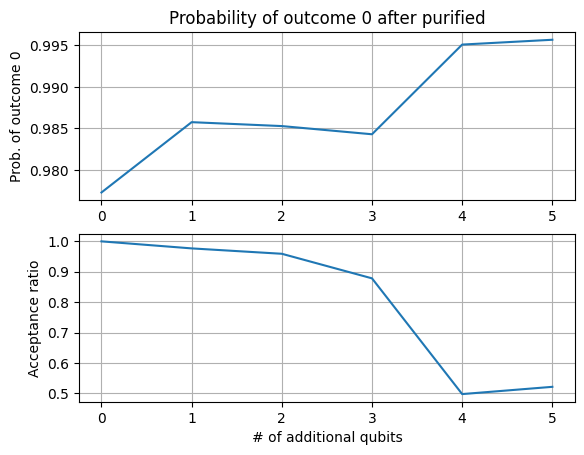

------------------------------
|            Done            |


In [52]:
distilled_data_all_ibm = {'#accepted':[],'#outcome0':[]}
probs_succ_all_ibm = {'mean':[],'variance':[]}
purified_fids_all_ibm = {'mean':[],'variance':[]}

print('===============================')
print("|  Purification post-process  |")
print('-------------------------------')

print('- Results')
print('-'*90)
print("n  | {0:<20} {1:<20} {2:<20} {3:<20}".format(
    'avg_prob_accepted','var_prob_accepted','avg_prob0_purified','var_prob0_purified'))
print('-'*90)
for num_add in range(max_add+1):
    prob_succ = 0
    prob_succ_sq = 0
    fidelity = 0
    fidelity_sq = 0
    for rep in range(repetitions_to_get_stats):
        idx = num_add*repetitions_to_get_stats + rep
        distilled_data = distiller(counts_all_experiments[idx], num_add, False)
        distilled_data_all_ibm['#accepted'].append(distilled_data[0])
        distilled_data_all_ibm['#outcome0'].append(distilled_data[1])

        prob_succ += distilled_data[0] / shots_per_experiment
        prob_succ_sq += (distilled_data[0] / shots_per_experiment) ** 2
        fidelity += distilled_data[1] / distilled_data[0]
        fidelity_sq += (distilled_data[1] / distilled_data[0]) ** 2
        
    probs_succ_all_ibm['mean'].append(prob_succ / repetitions_to_get_stats)
    probs_succ_all_ibm['variance'].append(
        (prob_succ_sq / repetitions_to_get_stats) - ((prob_succ / repetitions_to_get_stats) ** 2))
    purified_fids_all_ibm['mean'].append(fidelity / repetitions_to_get_stats)
    purified_fids_all_ibm['variance'].append(
        (fidelity_sq / repetitions_to_get_stats) - ((fidelity / repetitions_to_get_stats) ** 2))

    print("{0:<3}| {1:<20.8f} {2:<20.8f} {3:<20.8f} {4:<20.8f}".format(
        num_add, probs_succ_all_ibm['mean'][-1], probs_succ_all_ibm['variance'][-1], purified_fids_all_ibm['mean'][-1], purified_fids_all_ibm['variance'][-1]))

print('-'*90)

print('- Plots')
xaxis = np.array([n for n in range(max_add+1)])

for num_target in range(num_targets):
    plt.subplot(2,num_targets,2*num_target+1)
    plt.plot(xaxis, purified_fids_all_ibm['mean'])
    plt.ylabel('Prob. of outcome 0')
    plt.title('Probability of outcome 0 after purified')
    plt.grid(True)
    
    plt.subplot(2,num_targets,2*num_target+2)
    plt.plot(xaxis, probs_succ_all_ibm['mean'])
    plt.xlabel('# of additional qubits')
    plt.ylabel('Acceptance ratio')
    plt.grid(True)

plt.show()


print('------------------------------')
print("|            Done            |")
print('==============================')

### Purification (MATLAB)

|    Purification Simul.     |
------------------------------
- 62->61: [[0.9905466523698078,0.01017120983631218,0.10672065236937757]]
- Path is added: C:/Users/SEOSEUNGCHAN/Desktop/spam purification/spam_cnot_verification/matlab;
-+ Purification condition check:
-++ critical error rate of CNOT (e_c): 0.035445226912930575
-++ verified error rate of CNOT (e_v): 0.10672065236937757
-+++ Cannot be purified! (e_c < e_v)
-+ target 61
-++ prob0_purified: [0.99054665 0.97122304 0.97066152 0.97061425 0.97057874 0.97054065]
-++ prob_accepted: [1.         0.92991037 0.84886893 0.77451342 0.70668339 0.64481591]


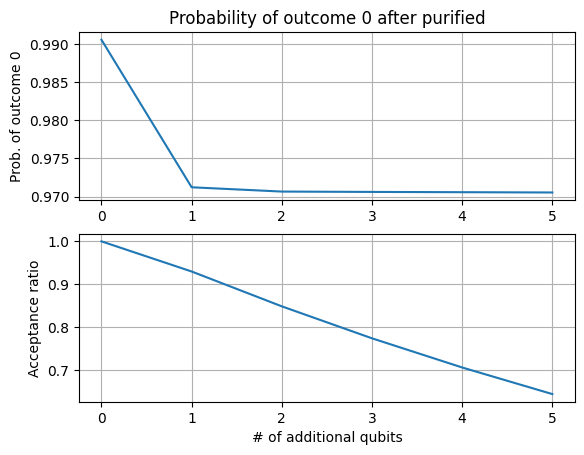

------------------------------
|            Done            |


In [54]:
import matplotlib.pyplot as plt

print('==============================')
print("|    Purification Simul.     |")
print('------------------------------')

xaxis = np.array([n for n in range(max_add+1)])

for target, fqe in solved_fqe.items():
    print('- {0}->{1}: {2}'.format(qubit_ctrl,target,fqe))

purified_fids_all_mat = {}
probs_succ_all_mat = {}
with matlab.engine.start_matlab() as me:
    subpath = me.genpath('C:/Users/SEOSEUNGCHAN/Desktop/spam purification/spam_cnot_verification/matlab')
    me.addpath(subpath, nargout=0)
    print('- Path is added: {}'.format(subpath))
    
    subplot_idx = 1
    for target, fqe_cap in solved_fqe.items():
        fqe = fqe_cap[0]
        #fqe[2] = 0.01 # to test if color is changed well
        e_c = (8*(fqe[0]**3)-12*(fqe[0]**2)+4*fqe[0]) / (8*(fqe[0]**3)-12*(fqe[0]**2)+4*fqe[0]-1)
        if e_c < fqe[2]:
            color = '\033[31m'
            ispossible = 'not'
        else:
            color = '\033[34m'
            ispossible = ''
        print('{}-+ Purification condition check:'.format(color))
        print('-++ critical error rate of CNOT (e_c): {}'.format(e_c))
        print('-++ verified error rate of CNOT (e_v): {}'.format(fqe[2]))
        print('-+++ Can{} be purified! (e_c < e_v)\033[0m'.format(ispossible))
        fouts = me.state_purify_py(fqe[0], fqe[1], fqe[2], max_add, nargout=2)
        purified_fids_all_mat[target] = np.array(fouts[0][0])
        probs_succ_all_mat[target] = np.array(fouts[1][0])
        print('-+ target {0}'.format(target))
        print('-++ prob0_purified: {0}'.format(purified_fids_all_mat[target][0]))
        print('-++ prob_accepted: {0}'.format(probs_succ_all_mat[target][0]))

        plt.subplot(2,num_targets,subplot_idx)
        subplot_idx += 1
        plt.plot(xaxis, purified_fids_all_mat[target].reshape(max_add+1))
        plt.ylabel('Prob. of outcome 0')
        plt.title('Probability of outcome 0 after purified')
        plt.grid(True)

        plt.subplot(2,num_targets,subplot_idx)
        subplot_idx += 1
        plt.plot(xaxis, probs_succ_all_mat[target].reshape(max_add+1))
        plt.xlabel('# of additional qubits')
        plt.ylabel('Acceptance ratio')
        plt.grid(True)

    plt.show()
    
print('------------------------------')
print("|            Done            |")
print('==============================')